In [1]:
import pandas as pd
import numpy as np

In [2]:
# Path to the CSV file
csv_file = 'C://Users//hp//Desktop//online_retail_dataset.csv'

# Read the file, replacing encoding errors
df = pd.read_csv(csv_file, encoding='unicode_escape')

In [3]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
df.tail()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,12/9/2011 12:50,4.95,12680.0,France
541909,581587,POST,POSTAGE,1,12/9/2011 12:50,18.00,12680.0,France


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Invoice      541910 non-null  object 
 1   StockCode    541910 non-null  object 
 2   Description  540456 non-null  object 
 3   Quantity     541910 non-null  int64  
 4   InvoiceDate  541910 non-null  object 
 5   Price        541910 non-null  float64
 6   Customer ID  406830 non-null  float64
 7   Country      541910 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [6]:
df.shape

(541910, 8)

In [7]:
df.describe()

,Quantity,Price,Customer ID
count,541910.000000,541910.000000,406830.000000
mean,9.552234,4.611138,15287.684160
std,218.080957,96.759765,1713.603074
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [8]:
df.ndim

2

In [9]:
df.isna().sum()

Invoice             0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
Price               0
Customer ID    135080
Country             0
dtype: int64

In [10]:
df = df.dropna(subset=['Customer ID'])

In [11]:
df = df.drop(columns=['Description'])

In [12]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df = df[df['Quantity'] > 0]

In [13]:
df['TotalPrice'] = df['Quantity'] * df['Price']

In [14]:
customer_lifetime_value = df.groupby('Customer ID')['TotalPrice'].sum().reset_index()
customer_lifetime_value.columns = ['Customer ID', 'LifetimeValue']

In [15]:
# Number of orders
order_counts = df.groupby('Customer ID')['Invoice'].nunique().reset_index()
order_counts.columns = ['Customer ID', 'OrderCount']

# Merge with lifetime value
customer_features = pd.merge(customer_lifetime_value, order_counts, on='Customer ID')

In [16]:
X = customer_features.drop(columns=['LifetimeValue'])
y = np.log1p(customer_features['LifetimeValue'])  # Apply log transformation

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
# Initialize the models
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Build the regression model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [24]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Predict on the test set
y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)  # Inverse log transformation

# Evaluate the model
print("MAE:", mean_absolute_error(np.expm1(y_test), y_pred))
print("MSE:", mean_squared_error(np.expm1(y_test), y_pred))
print("R-squared:", r2_score(np.expm1(y_test), y_pred))

MAE: 43031.42398737405
MSE: 1329904711793.142
R-squared: -15364.672746858323


In [25]:
# Display predictions and actual values
predictions = pd.DataFrame({
    'Customer ID': X_test['Customer ID'],
    'Actual Lifetime Value': np.expm1(y_test),
    'Predicted Lifetime Value': y_pred
})
print(predictions.head())


      Customer ID  Actual Lifetime Value  Predicted Lifetime Value
3976      17785.0                 131.94                460.886285
1448      14317.0                 508.58                566.093225
2663      15977.0                1054.73                562.079126
17        12364.0                1313.10                835.683218
1634      14565.0                3099.12                733.514827


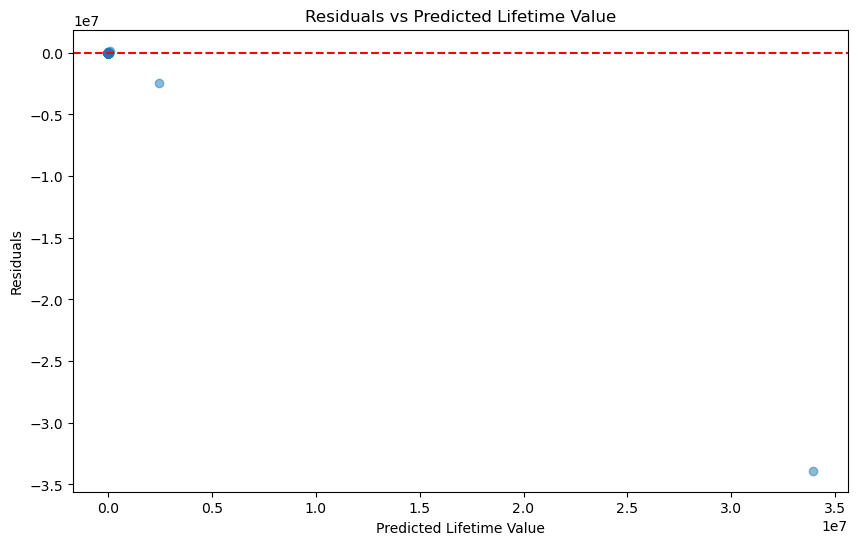

In [27]:
# Residual Analysis
residuals = np.expm1(y_test) - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.xlabel('Predicted Lifetime Value')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Lifetime Value')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()